<a href="https://colab.research.google.com/github/ANSHTHAKUR07/Vision-plant-des/blob/main/trainin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 5308 images belonging to 4 classes.
Found 1329 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 1771s 10s/step - accuracy: 0.4942 - loss: 1.2044 - val_accuracy: 0.2415 - val_loss: 99.1016 - learning_rate: 0.0010
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 116s 546ms/step - accuracy: 0.6624 - loss: 0.7958 - val_accuracy: 0.2415 - val_loss: 56.5351 - learning_rate: 0.0010
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 546ms/step - accuracy: 0.7009 - loss: 0.7272 - val_accuracy: 0.2874 - val_loss: 663.9290 - learning_rate: 0.0010
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 90s 544ms/step - accuracy: 0.7227 - loss: 0.7047 - val_accuracy: 0.2874 - val_loss: 651.3574 - learning_rate: 0.0010
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 547ms/step - accuracy: 0.7454 - loss: 0.6307 - val_accuracy: 0.5064 - val_loss: 58.5900 - learning_rate: 0.0010
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 546ms/step - accuracy: 0.7656 - loss: 0.5705 - val_accuracy: 0.5297 - val_loss: 4.8962 - learning_rate: 2.0000e-04
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 91s 550ms/step - a

✅ Model saved!


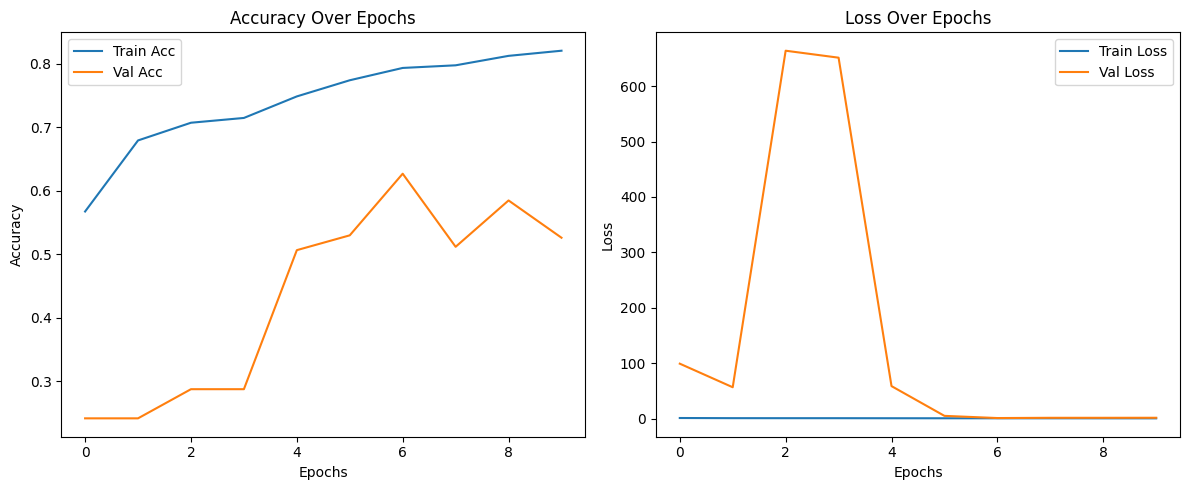

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

# Data paths
train_dir = '/content/drive/MyDrive/PlantVillage/plant_train'
val_dir = '/content/drive/MyDrive/PlantVillage/plant_val'

# Image preprocessing
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode='categorical')

val_gen = val_datagen.flow_from_directory(val_dir,
                                          target_size=IMAGE_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode='categorical')

# Hybrid Model: EfficientNetB0 + ResNet50
input_tensor = Input(shape=(224, 224, 3))

# Load EfficientNetB0 and ResNet50 with weights
base1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
base2 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Unfreeze more layers to fine-tune (top layers) of both models
for layer in base1.layers[:200]:  # Freeze first 200 layers
    layer.trainable = False
for layer in base2.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Add the custom layers for classification
x1 = GlobalAveragePooling2D()(base1.output)
x2 = GlobalAveragePooling2D()(base2.output)

combined = Concatenate()([x1, x2])
x = Dropout(0.3)(combined)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping and Learning Rate Scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    callbacks=[early_stopping, lr_scheduler])

# Save model
model.save('/content/drive/MyDrive/PlantVillage/hybrid_efficientnet_resnet_model.h5')
print("✅ Model saved!")

# Accuracy and loss plots
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions on validation data
val_preds = model.predict(val_gen, verbose=1)
val_preds_classes = np.argmax(val_preds, axis=1)

# True labels
val_true_classes = val_gen.classes

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(val_true_classes, val_preds_classes, target_names=train_gen.class_indices.keys())
print("Classification Report:\n", class_report)

# Optionally, save the classification report
with open('/content/drive/MyDrive/PlantVillage/classification_report.txt', 'w') as f:
    f.write(class_report)


42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step
Classification Report:
                        precision    recall  f1-score   support

Tomato_Bacterial_spot       0.33      0.22      0.26       426
  Tomato_Early_blight       0.33      0.01      0.02       200
   Tomato_Late_blight       0.30      0.60      0.40       382
       Tomato_healthy       0.23      0.20      0.21       321

             accuracy                           0.29      1329
            macro avg       0.30      0.26      0.22      1329
         weighted avg       0.30      0.29      0.25      1329



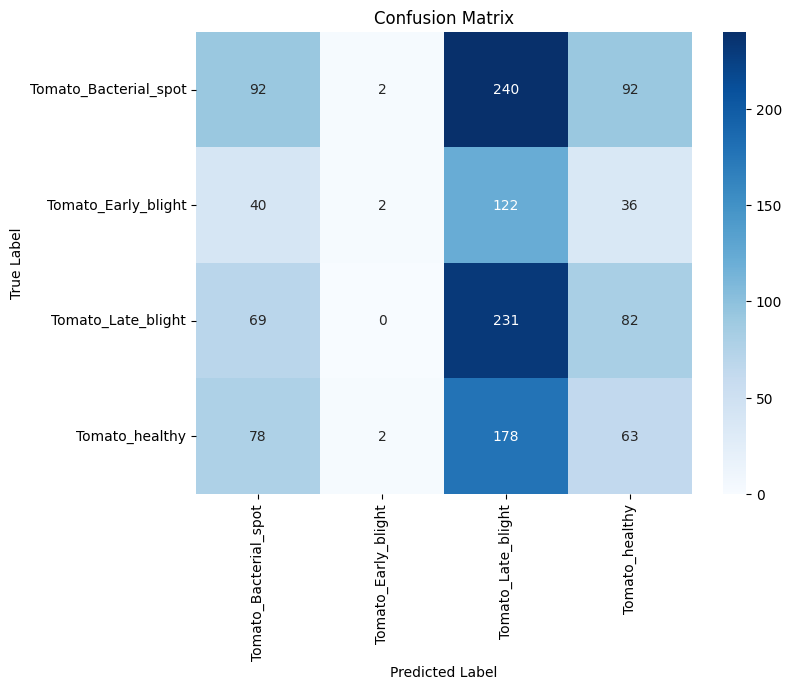

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optionally, save the confusion matrix
np.save('/content/drive/MyDrive/PlantVillage/confusion_matrix.npy', conf_matrix)


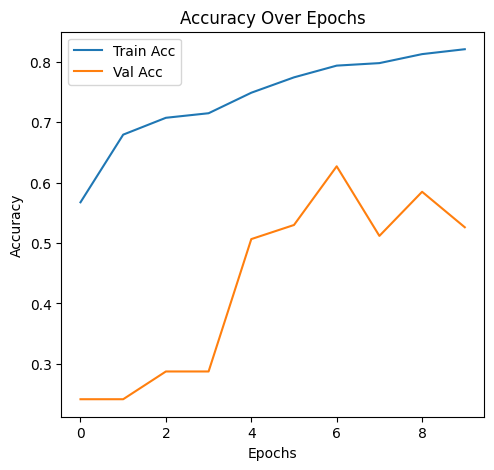

In [8]:
# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


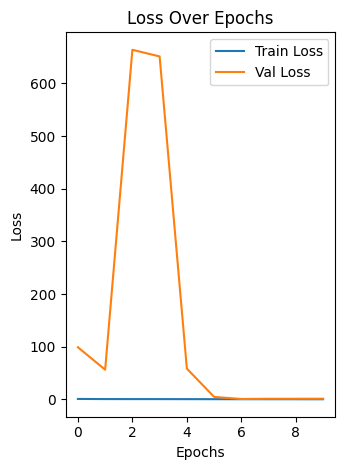

In [9]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
